# Evaluate ensemble members

The goal of this script is to identify ensemble members that meet specific ecological criteria

In [4]:
import pandas as pd
import numpy as np
import os
import sys
#Path to the esm_tools.py script
sys.path.append('/glade/u/home/adamhb/Earth-System-Model-Tools')
import esm_tools
import importlib
importlib.reload(esm_tools)
pd.set_option('display.max_rows', 1000) 
import shutil
import re
import fnmatch
import math
from matplotlib import pyplot as plt
pd.set_option('display.max_colwidth', None)

In [6]:
write_csv_of_passing_members = True
setup_new_simulation = True
check_CZ2_100_yrs = False
check_CZ2_PEAS = False
new_case_is_fire_suppression = False
new_run_is_hybrid = True
check_transient_vs_precolonial = True
check_CZ2_vs_STAN = False

new_subdirs_prefix = None
harmonized_reference_case_name=None
destination_run_dir=None

if write_csv_of_passing_members == True:
    output_file_path = '/glade/work/adamhb/processed_output/passing_fire_regime_012924.csv'

# Path to ensemble data to be evaluated
path_to_ensemble_data = '/glade/derecho/scratch/adamhb/processed_output/CZ2_equilibrium_011824_-17e2acb6a_FATES-5b076b69/ensemble_output_CZ2_equilibrium_011824_-17e2acb6a_FATES-5b076b69_structure_metrics_last3_years_20240119131014.csv'

# Path to where ensemble parameter files are stored
path_to_ensemble_param_files_root = '/glade/u/home/adamhb/ahb_params/fates_api_25/ensembles/'

key_metrics = ['inst_id','BA','ShannonE','AGB','BA_pine','BA_cedar','BA_fir','BA_shrub','BA_oak',
'FailedPFTs','Pct_shrub_cover_canopy','Pct_shrub_cover','TreeStemD','TreeStemD_40','TreeStemD_60',
               'TreeStemD_80','TreeStemD_100','ResproutD_oak','ResproutD_shrub','NPP','Combustible_fuel']#,
#'Burned_area','Pct_high_severity_1700','Pct_high_severity_3500']

## Functions

In [7]:
def delete_all_files_in_directory(directory_path):
    try:
        # List all files in the directory
        file_list = os.listdir(directory_path)

        # Iterate over the files and delete them
        for file_name in file_list:
            file_path = os.path.join(directory_path, file_name)
            if os.path.isfile(file_path):
                os.remove(file_path)
        
        print(f"All files in {directory_path} have been deleted.")
    except Exception as e:
        print(f"An error occurred: {e}")


def get_most_recent_file_in_dir(folder_path):

    # Get a list of all files in the folder
    files = os.listdir(folder_path)

    # Filter out only files (excluding subdirectories)
    files = [file for file in files if os.path.isfile(os.path.join(folder_path, file))]

    # Sort the files by creation time (most recent first)
    files.sort(key=lambda x: os.path.getctime(os.path.join(folder_path, x)), reverse=True)

    # Check if there are any files in the folder
    if files:
        most_recent_file = files[0]
        print(f"The most recently created file is: {most_recent_file}")
        return most_recent_file
    else:
        print("The folder is empty.")

        

        
def aggregate_passing_paramsets(successfull_param_files,n_new_cases,n_inst_per_case,new_subdirs_prefix,
                                path_to_ensemble_param_files_root,new_param_file_base_name,fire_suppression = False,
                                nignitions = 0.055, fire_thresh = 1000):
    
    '''
    This function relabels and prepares parameter sets that passed criteria for a new group of cases to be run
    '''
    
    os.makedirs("tmp",exist_ok=True)
    delete_all_files_in_directory("tmp")
    
    # Make new subdirectories for the parameter files for the new cases
    for n in range(n_new_cases):
        new_param_subdir_suffix = str(n+1).rjust(2, '0')
        new_param_subdir = os.path.join(path_to_ensemble_param_files_root,new_subdirs_prefix) + "_" + new_param_subdir_suffix
        os.makedirs(new_param_subdir,exist_ok=True)
    
    
    # Put all successful param files in a temp direcotry
    tmp_inst = 0
    for reference_param_file in successfull_param_files:
        
        # Number them 0001 ... n
        tmp_inst = tmp_inst + 1
        
        # Get full path of originl param file
        ref_nc_file_full_path = reference_param_file
        print("originl_file:",ref_nc_file_full_path)

        #Copy to reference param file to new folder
        
        new_tag = str(tmp_inst).rjust(4, '0')
        new_name = new_param_file_base_name + "_" + new_tag + ".nc"
        dst_file = os.path.join("tmp",new_name)
        print("tmp file:",dst_file)
        shutil.copy(ref_nc_file_full_path,dst_file)
        
        # Generate new case tags for a new group of cases
        new_case_tags = [str(case_tag+1).rjust(2, '0') for case_tag in range(n_new_cases)]
         
    for i,new_case_tag in enumerate(new_case_tags):
            
            print("\n")
            
            # Make new subdir for the new cases
            #if len(new_case_tags) == 1:
            #    new_param_subdir = os.path.join(path_to_ensemble_param_files_root,new_subdirs_prefix)
            
            #else:
            new_param_subdir = os.path.join(path_to_ensemble_param_files_root,new_subdirs_prefix) + "_" + new_case_tag
            
            tmp_inst = i * n_inst_per_case
            
            for j in range(n_inst_per_case):
                
                tmp_inst = tmp_inst + 1
                tmp_inst_tag = str(tmp_inst).rjust(4, '0')
                
                 # Get temp param file with inst tag
                ref_nc_file = esm_tools.find_files_with_substring(directory="tmp",
                                                substring=tmp_inst_tag)

                # Get full path of originl param file
                ref_nc_file_full_path = os.path.join("tmp",ref_nc_file[0])
                
                print("tmp_file:",ref_nc_file_full_path)
                
                new_tag = str(j + 1).rjust(4, '0')
                new_name = new_param_file_base_name + "_" + new_tag + ".nc"
                dst_file = os.path.join(path_to_ensemble_param_files_root,new_param_subdir,new_name)
                
                shutil.copy(ref_nc_file_full_path,dst_file)
                
                
                # pick up here
                if new_case_is_fire_suppression == True:
                    esm_tools.assign_var_to_nc(dst_file,"fates_fire_nignitions",nignitions,0)
                    esm_tools.assign_var_to_nc(dst_file,"fates_fire_threshold",fire_thresh,0)
                
                
                print("destination:",dst_file)

def harmonic_mean(numbers):
    # Ensure the list is not empty and does not contain zero to avoid division by zero
    if not numbers or 0 in numbers:
        return None

    # Calculate the sum of the reciprocals of the numbers
    sum_of_reciprocals = sum(1 / x for x in numbers)
    
    # Calculate the harmonic mean
    return len(numbers) / sum_of_reciprocals

def root_mean_square(numbers):
    # Check if the list is empty to avoid division by zero
    if not numbers.all():
        return None
    
    # Calculate the squares and mean
    mean_of_squares = sum(x**2 for x in numbers) / len(numbers)
    
    # Return the square root of the mean of squares
    return math.sqrt(mean_of_squares)

## Load ensemble data

In [18]:
df = pd.read_csv(path_to_ensemble_data)
df = df.drop(df.columns[0], axis=1)
df

,BA,AGB,TreeStemD,TreeStemD_40,TreeStemD_60,TreeStemD_80,TreeStemD_100,ResproutD_oak,ResproutD_shrub,ShannonE,...,fates_allom_d2ca_coefficient_max_1,fates_allom_d2ca_coefficient_max_2,fates_allom_d2ca_coefficient_max_3,fates_allom_d2ca_coefficient_max_4,fates_allom_d2ca_coefficient_max_5,fates_allom_d2ca_coefficient_min_0,fates_allom_agb1_1,fates_allom_agb1_2,fates_allom_agb1_3,fates_allom_agb1_5
0,21.981668,4.775533,308.425725,18.389894,13.470057,2.750178,9.273586e-01,19.211191,0.003118,0.560473,...,0.267312,0.267312,0.267312,0.224899,0.834196,0.267312,0.068924,0.068924,0.068924,0.091215
1,10.706932,3.554558,143.966824,9.882356,2.985984,1.022661,3.408821e-01,26.195620,0.021297,0.721348,...,0.311242,0.311242,0.311242,0.190033,0.751145,0.311242,0.072201,0.072201,0.072201,0.102339
2,13.007200,2.776733,255.824700,31.566794,4.670146,4.051115,1.122624e+00,35.955814,0.007813,0.851354,...,0.279736,0.279736,0.279736,0.265844,0.657261,0.279736,0.065708,0.065708,0.065708,0.094992
3,6.733777,2.625335,154.704973,5.604480,0.396227,0.008754,3.850410e-04,12.410482,4.629446,0.528744,...,0.379334,0.379334,0.379334,0.202152,0.485258,0.379334,0.080888,0.080888,0.080888,0.099982
4,14.177242,4.115454,291.985646,26.939260,3.043046,0.254908,5.696321e-04,6.081196,0.000000,0.512718,...,0.374971,0.374971,0.374971,0.181367,0.438946,0.374971,0.067826,0.067826,0.067826,0.094041
5,13.372872,4.040996,163.351148,7.529354,0.798161,0.744525,7.363886e-01,35.823254,0.000000,0.236410,...,0.421716,0.421716,0.421716,0.221710,0.645705,0.421716,0.068210,0.068210,0.068210,0.097660
6,6.523458,2.482201,43.849163,2.868786,0.744184,0.584726,1.843930e-01,281.874970,1.518907,0.591543,...,0.348831,0.348831,0.348831,0.250844,1.257653,0.348831,0.079338,0.079338,0.079338,0.096744
7,23.465542,5.611041,234.635584,39.686868,16.714050,14.532455,1.098656e-01,4.516918,0.000000,0.441404,...,0.346427,0.346427,0.346427,0.235195,0.794789,0.346427,0.070691,0.070691,0.070691,0.092170
8,15.421281,5.455863,181.077160,30.151939,10.181656,0.006228,0.000000e+00,1.398476,0.000000,0.505099,...,0.273187,0.273187,0.273187,0.159704,0.454956,0.273187,0.082523,0.082523,0.082523,0.106608
9,4.452289,2.277078,76.774284,2.989400,2.335169,0.529855,1.472296e-01,8.475993,2.314550,0.433170,...,0.388225,0.388225,0.388225,0.204737,0.439578,0.388225,0.069972,0.069972,0.069972,0.097701


## Ecological expectations and preliminary filters

### Check on coexistence and extreme shrub dominance at 100 years

In [20]:
if check_CZ2_100_yrs == True:
    
    # Filter criteria
    filter_at_100_yrs = (df['FailedPFTs'] == 0) & (df['Pct_shrub_cover'] > 0.01) & (df['Pct_shrub_cover_canopy'] < 0.65)
    
    
    number_passing = len(df[filter_at_100_yrs])
    print(number_passing, "pass check on coexistence and shrub dominance")
    print(number_passing / len(df) * 100,"percent success")
    df_passing_CZ2_100_yrs = df[filter_at_100_yrs].sort_values("ShannonE",ascending = False)
    if write_csv_of_passing_members == True:
        df_passing_CZ2_100_yrs.to_csv(output_file_path)
        print("Wrote file:",output_file_path)
    #df_passing_CZ2_100_yrs[key_metrics]
    
    
    if setup_new_simulation == True:
        aggregate_passing_paramsets(successfull_param_files = list(df_passing_CZ2_100_yrs['param_file_path']),
                                n_new_cases = 7,
                                n_inst_per_case = 72,
                                new_subdirs_prefix = "CZ2_equilibrium_110523", # Without underscore
                                path_to_ensemble_param_files_root = path_to_ensemble_param_files_root,
                                new_param_file_base_name = 'CZ2_equilibrium_110523') # Without underscore

### CZ2, Pre-Euro-American Management, equilibrium, no fire metrics

This code was used to filter the ensemble members that were run to equilibrium at CZ2 to get the 54 members that generated a PEAS forest at CZ2 that passed some simple sanity checks. This code was also used to add a score to each ensemble member. Fire metrics were not done at this stage. Fire metrics were subsequently calculated for the 54 members generated here in a separate csv file.

In [27]:
if check_CZ2_PEAS == True:

    # Burned area
#     if 'Burned_area' in key_metrics:
#         ba_dry = (df['Burned_area'] > 0.0294) & (df['Pct_high_severity_1700'] < 0.0909) # Williams et al., 2023
#         print(sum(ba_dry),"are within range of observations for burned area")

#         # Percent high severity
#         phs_dry = (df['Pct_high_severity_1700'] > 1) & (df['Pct_high_severity_1700'] < 6)
#         print(sum(phs_dry),"are within obs for PHS 1700 kW m-1")
#         phs_dry = (df['Pct_high_severity_3500'] > 1) & (df['Pct_high_severity_3500'] < 6)
#         print(sum(phs_dry),"are within obs for PHS 3500 kW m-1")

    # Shrub cover
    #shrub_cov = (df['Pct_shrub_cover'] > 0.14) & (df['Pct_shrub_cover'] < 0.32)
    #print(sum(shrub_cov),"are within range of obs for shrub cover")

    # Pine significant
    #df["pine_frac"] = df["BA_pine"] / df["BA"]

    #pine_frac_thresh = 0.10
    #pine_sig = df['pine_frac'] > pine_frac_thresh
    #print(sum(pine_sig),'have pine basal area >', pine_frac_thresh)

    # All metrics
    #if 'Burned_area' in key_metrics:
    #    all_metrics = len(df.loc[ba_dry & phs_dry & shrub_cov & pine_sig])
    #    print(all_metrics,'meet all expectations for CZ2 PEAS')
    
    # Sort by failed pfts and Shannon E
    #df = df.sort_values(["FailedPFTs","ShannonE"],ascending=[True,False])
    
    
    # Score each param set based on structural variables
    #########
    #Targets#
    #########
    
#     BA_target = 20
#     BA_pine_target = 12
#     BA_cedar_target = 6
#     BA_fir_target = 1
#     BA_oak_target = 3 # This is assumed
#     Stem_den_target = 144 # > 10 cm, Safford and Stevens, 2017
#     Stem_den_40_target = 65
#     Stem_den_60_target = 43
#     Stem_den_80_target = 29
#     Stem_den_100_target = 17
#     Shrub_cov_target = 0.23
    
#     targets = [20,12,6,1,3,144,65,43,29,17,0.23]
    
#     def get_benchmark_scores(targets,df):
        
#         # Get standardized predictions
#         pred_fields = ["BA","BA_pine","BA_cedar","BA_fir","BA_oak",
#                        "TreeStemD", "TreeStemD_40","TreeStemD_60",
#                        "TreeStemD_80","TreeStemD_100","Pct_shrub_cover"]
#         data = np.array(df[pred_fields])
#         std = data.std(axis = 0)
#         mean = data.mean(axis = 0)
#         data -= mean
#         data /= std
        
#         # Get standardized targets
#         std_targets = (np.array(targets) - mean) / std
        
#         scores = []
        
#         for row in range(data.shape[0]):
#             preds = data[row,:]
#             biases = std_targets - preds
#             scores.append(root_mean_square(biases))
#         return scores
    
#     # Generate the scores
#     scores = get_benchmark_scores(targets,df)
#     df['rmse'] = scores
    
    # Filter to members that pass some simple sanity checks on what a pre-colonial forest should look like
    
    # There should be at least 5 tree above 40 cm dbh
    enough_large_trees = df["TreeStemD_40"] > 5
    
    # There should be at least 5 percent total shrub cover
    enough_shrubs = df["Pct_shrub_cover"] > 0.05
    
    # Pine should not be failing
    enough_pine = df["BA_pine"] > 0.1
    
    # There should be no more than 2 pfts failing
    coexistence_filter = df["FailedPFTs"] < 3
    
    # AGB should be at least 2 Kg of Carbon per m2
    enough_agb = df["AGB"] > 2
    
    # All filters
    all_filters = enough_large_trees & enough_shrubs & enough_pine & coexistence_filter & enough_agb
    
    #df = df[all_filters]
    print("There are",len(df[all_filters]),"passing parameter sets")
    
        
    if setup_new_simulation == True:
        # Add the tag number of the next simulation to the passing ensemble member csv so that it can later be used
        # to match structure metrics from CZ2-PEAS to CZ2-trans
        next_inst_nums = list(range(1,len(df) + 1))
        next_inst_tags = [str(num).rjust(4, '0') for num in next_inst_nums]
        df["CZ2-trans-id"] = [new_subdirs_prefix + "_" + tag for tag in next_inst_tags]
    
    #key_metrics.append("rmse")
    
    # Write csv of passing members
    if write_csv_of_passing_members == True:
        df_passing = df[all_filters]
        df_passing.to_csv(output_file_path)
        print("Wrote structure metrics for param sets that pass CZ2-PEAS:",output_file_path)
    
    if setup_new_simulation == True:
        aggregate_passing_paramsets(successfull_param_files = list(df['param_file_path']),
                                n_new_cases = 1,
                                n_inst_per_case = len(df),
                                new_subdirs_prefix = new_subdirs_prefix, # Without underscore
                                path_to_ensemble_param_files_root = path_to_ensemble_param_files_root,
                                new_param_file_base_name = 'ca_5pfts_100523') # Without underscore

There are 33 passing parameter sets
Wrote structure metrics for param sets that pass CZ2-PEAS: /glade/derecho/scratch/adamhb/processed_output/CZ2-PEAS_passing_no_fire_011924.csv


### Make bar chart showing how many members passed each criterion

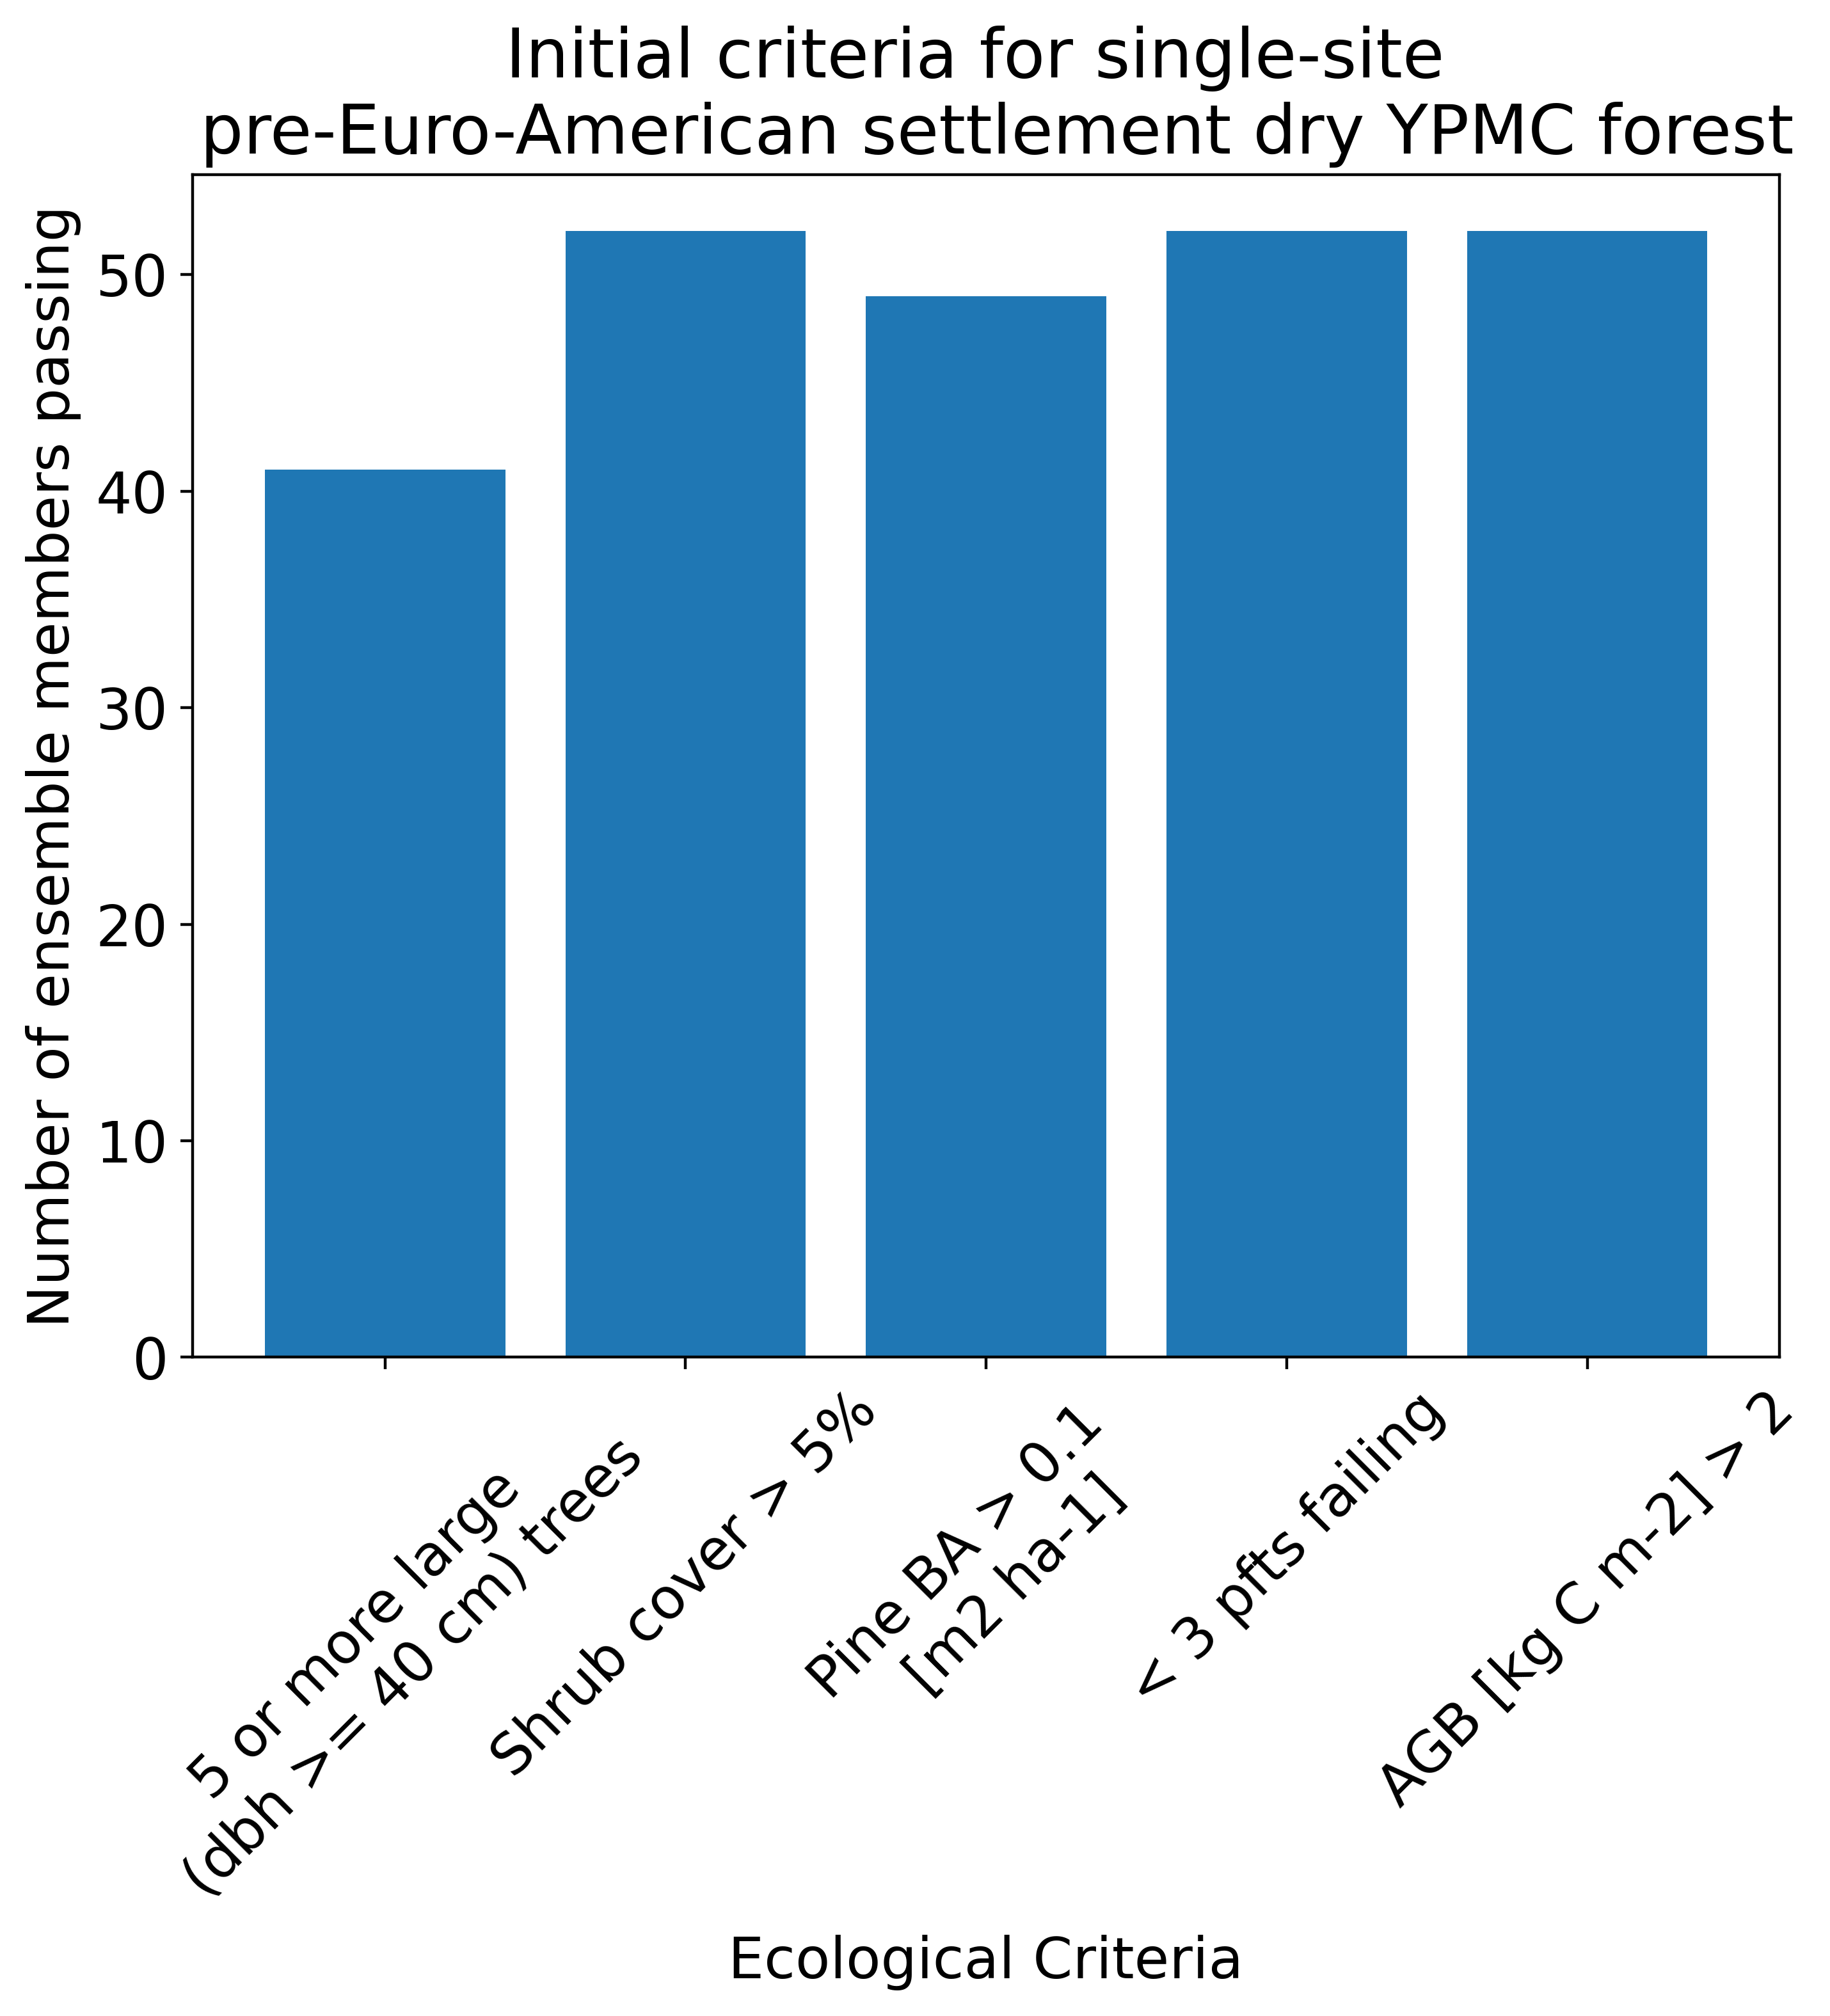

In [24]:
bar_chart_titles = ['5 or more large \n (dbh >= 40 cm) trees','Shrub cover > 5%','Pine BA > 0.1 \n [m2 ha-1]','< 3 pfts failing','AGB [kg C m-2] > 2']
n_per_category = [np.sum(np.array(arr)) for arr in [enough_large_trees, enough_shrubs, enough_pine, coexistence_filter, enough_agb]]

fig, ax = plt.subplots(figsize=(8, 6), dpi=400)

plt.rc('font', size=16)
ax.bar(bar_chart_titles, n_per_category)

# Add labels and a title
plt.xlabel('Ecological Criteria')  # X-axis label
plt.ylabel('Number of ensemble members passing')      # Y-axis label
plt.title('Initial criteria for single-site \n pre-Euro-American settlement dry YPMC forest')
plt.xticks(rotation=45)
plt.savefig("/glade/u/home/adamhb/california-fates/figures/CZ-PEAS-initial-criteria.pdf", format="pdf", bbox_inches="tight")

## Write successfull param files to text

In [ ]:
# my_list = df['param_file_path']

# with open("successful_param_sets_54_111023.txt", "w") as file:
#     # Loop through each element in the list
#     for item in my_list:
#         # Write the element to the file followed by a newline character
#         file.write(item + "\n")

## Pft responses to fire regime

In [10]:
if check_transient_vs_precolonial == True:
    
    # Criteria
    def get_change_in_metric(expect_larger_data,expect_smaller_data,pft_name,metric = "BA_dominance"):
        
        
        if metric == "BA_dominance":
            pft_ba = "BA_" + pft_name

            expect_larger_data_frac_of_total = expect_larger_data[pft_ba] / expect_larger_data['BA']
            #print("Scenario A Frac",scenarioA_frac_of_total)
            
            expect_smaller_data_frac_of_total = expect_smaller_data[pft_ba] / expect_smaller_data['BA']
            #print("Scenario B Frac",scenarioB_frac_of_total)
            
            response = expect_larger_data_frac_of_total > expect_smaller_data_frac_of_total
        
        
        if metric == "BA":
            pft_ba = "BA_" + pft_name
            response = expect_larger_data[pft_ba] > expect_smaller_data[pft_ba]
        
        if metric == "Conifer BA":
            conifer_ba_larger = np.sum(np.array(expect_larger_data[['BA_pine','BA_cedar','BA_fir']]),axis = 0)
            conifer_ba_smaller = np.sum(np.array(expect_smaller_data[['BA_pine','BA_cedar','BA_fir']]),axis = 0)
            
            response = conifer_ba_larger > conifer_ba_smaller
        
        if metric == "Pct_shrub_cover":
            
            response = expect_larger_data["Pct_shrub_cover"] > expect_smaller_data["Pct_shrub_cover"]
        
        
        if metric == "TreeStemD":
            response = expect_larger_data["TreeStemD"] > expect_smaller_data["TreeStemD"]
            
        if metric == "Burned_area":
            response = expect_larger_data["Burned_area"] > expect_smaller_data["Burned_area"]
        
        # doing greater or equal here to account for zero fires of high severity
        if metric == "Pct_high_severity_1700":
            response = expect_larger_data["Pct_high_severity_1700"] >= expect_smaller_data["Pct_high_severity_1700"]
            
        # if response == False:
        #     print(metric,pft_name,response)
        
        return response    
    
    
    # The datasets here can be without the parameter values, but need to have the inst ids
    def pft_response_to_fire_regime(PEAS_data,TRANS_data):
        
        #print("\n")
        #print("Ensemble member:",PEAS_data['CZ2-trans-id'])
        
        if PEAS_data['fates_leaf_vcmax25top_1'] != TRANS_data['fates_leaf_vcmax25top_1']:
            return
        
        # else:
        #     print("Data don't match, ABORT")
        #     return
        
#         if TRANS_data['Burned_area'] > 0.01:
#             print("TRANS fire regime has more burned area than 1984 to 2009")
#             print("Burned area:",TRANS_data['Burned_area'])
        
#         if TRANS_data['Pct_high_severity_3500'] > 31:
#             print("TRANS fire regime has more high severity fire than 1984 to 2009")
#             print("PHS 3500:",TRANS_data['Pct_high_severity_3500'])
        
        
        if (TRANS_data['Burned_area'] > 0.01) & (TRANS_data['Pct_high_severity_3500'] > 31):
            fire_regime = "Post-2010-fire"
        else:
            fire_regime = "Pre-2010-suppression-fire"
        
        # 1. Increase in fir dominance with fire suppression
        fir_response_dominance = get_change_in_metric(expect_larger_data=TRANS_data,
                                                      expect_smaller_data=PEAS_data,
                                                      pft_name="fir")
        
        fir_response_ba = get_change_in_metric(expect_larger_data=TRANS_data,
                                               expect_smaller_data=PEAS_data,
                                               pft_name="fir",
                                               metric="BA")
        
        fir_response = fir_response_dominance or fir_response_ba
        
        
        # 2. Increase in cedar dominance with fire suppression
        cedar_response_dominance = get_change_in_metric(expect_larger_data=TRANS_data,
                                              expect_smaller_data=PEAS_data,
                                              pft_name="cedar")
        
        cedar_response_ba = get_change_in_metric(expect_larger_data=TRANS_data,
                                              expect_smaller_data=PEAS_data,
                                              pft_name="cedar",
                                                metric="BA")
        cedar_response = cedar_response_dominance or cedar_response_ba
        
        
        # These next two really depend on the state of the TRANS fire regime
        # are we in a situation where burned area is coming back up?
        # are we in a situation where fire intensity is coming back up?
        
        # 3. Higher in pine dominance during PEAS
        pine_response_dominance = get_change_in_metric(expect_larger_data=PEAS_data,
                                             expect_smaller_data=TRANS_data,
                                             pft_name="pine")
        
        pine_response_ba = get_change_in_metric(expect_larger_data=PEAS_data,
                                             expect_smaller_data=TRANS_data,
                                             pft_name="pine",metric="BA")
        
        pine_response = pine_response_dominance or pine_response_ba
        
        # 4. Higher oak dominance during PEAS
        oak_response_dominance = get_change_in_metric(expect_larger_data=PEAS_data,
                                            expect_smaller_data=TRANS_data,
                                            pft_name="oak")
        
        oak_response_ba = get_change_in_metric(expect_larger_data=PEAS_data,
                                            expect_smaller_data=TRANS_data,
                                            pft_name="oak",metric="BA")
        
        if fire_regime == "Pre-2010-suppression-fire":
            oak_response = oak_response_dominance or oak_response_ba
        else:
            oak_response = True
        
        # 5. Lower shrub cover during fire suppression
        shrub_response = get_change_in_metric(expect_larger_data=PEAS_data,
                                              expect_smaller_data=TRANS_data,
                                              pft_name="shrub",metric="Pct_shrub_cover")
        
        # 6. Stem density increase during suppression
        stem_den_response = get_change_in_metric(expect_larger_data=TRANS_data,
                                              expect_smaller_data=PEAS_data,
                                              pft_name=None,metric="TreeStemD")
        
        
        # 7. Burned area response decrease during suppression
        burned_area_response = get_change_in_metric(expect_larger_data=PEAS_data,
                                              expect_smaller_data=TRANS_data,
                                              pft_name=None,metric="Burned_area")
        
        # 8 PHS 1700 increases during suppression
        PHS_1700_response = get_change_in_metric(expect_larger_data=TRANS_data,
                                              expect_smaller_data=PEAS_data,
                                              pft_name=None,metric="Pct_high_severity_1700")
        
        
        responses = np.array([oak_response,
                              fir_response,
                              cedar_response,
                              shrub_response,
                              stem_den_response,
                              burned_area_response,
                              PHS_1700_response])
        
        pass_fire_response = oak_response and shrub_response and stem_den_response and burned_area_response and PHS_1700_response
        
        pft_response_score = np.sum(responses) / len(responses)
        
        #print(pft_response_score)
        
        return pass_fire_response, pft_response_score, oak_response, fir_response, cedar_response, shrub_response, stem_den_response, burned_area_response, PHS_1700_response

In [ ]:
if check_transient_vs_precolonial == True:
    
    # Criteria
    def get_change_in_metric(expect_larger_data,expect_smaller_data,pft_name,metric = "BA_dominance"):
        
        
        if metric == "BA_dominance":
            pft_ba = "BA_" + pft_name

            expect_larger_data_frac_of_total = expect_larger_data[pft_ba] / expect_larger_data['BA']
            #print("Scenario A Frac",scenarioA_frac_of_total)
            
            expect_smaller_data_frac_of_total = expect_smaller_data[pft_ba] / expect_smaller_data['BA']
            #print("Scenario B Frac",scenarioB_frac_of_total)
            
            response = expect_larger_data_frac_of_total > expect_smaller_data_frac_of_total
        
        
        if metric == "BA":
            pft_ba = "BA_" + pft_name
            response = expect_larger_data[pft_ba] > expect_smaller_data[pft_ba]
        
        if metric == "Conifer BA":
            conifer_ba_larger = np.sum(np.array(expect_larger_data[['BA_pine','BA_cedar','BA_fir']]),axis = 0)
            conifer_ba_smaller = np.sum(np.array(expect_smaller_data[['BA_pine','BA_cedar','BA_fir']]),axis = 0)
            
            response = conifer_ba_larger > conifer_ba_smaller
        
        if metric == "Pct_shrub_cover":
            
            response = expect_larger_data["Pct_shrub_cover"] > expect_smaller_data["Pct_shrub_cover"]
        
        
        if metric == "TreeStemD":
            response = expect_larger_data["TreeStemD"] > expect_smaller_data["TreeStemD"]
            
        if metric == "Burned_area":
            response = expect_larger_data["Burned_area"] > expect_smaller_data["Burned_area"]
        
        # doing greater or equal here to account for zero fires of high severity
        if metric == "Pct_high_severity_1700":
            response = expect_larger_data["Pct_high_severity_1700"] >= expect_smaller_data["Pct_high_severity_1700"]
            
        # if response == False:
        #     print(metric,pft_name,response)
        
        return response    
    
    
    # The datasets here can be without the parameter values, but need to have the inst ids
    def pft_response_to_fire_regime(PEAS_data,TRANS_data):
        
        #print("\n")
        #print("Ensemble member:",PEAS_data['CZ2-trans-id'])
        
        if PEAS_data['fates_leaf_vcmax25top_1'] != TRANS_data['fates_leaf_vcmax25top_1']:
            return
        
        # else:
        #     print("Data don't match, ABORT")
        #     return
        
#         if TRANS_data['Burned_area'] > 0.01:
#             print("TRANS fire regime has more burned area than 1984 to 2009")
#             print("Burned area:",TRANS_data['Burned_area'])
        
#         if TRANS_data['Pct_high_severity_3500'] > 31:
#             print("TRANS fire regime has more high severity fire than 1984 to 2009")
#             print("PHS 3500:",TRANS_data['Pct_high_severity_3500'])
        
        
        if (TRANS_data['Burned_area'] > 0.01) & (TRANS_data['Pct_high_severity_3500'] > 31):
            fire_regime = "Post-2010-fire"
        else:
            fire_regime = "Pre-2010-suppression-fire"
        
        # 1. Increase in fir dominance with fire suppression
        fir_response_dominance = get_change_in_metric(expect_larger_data=TRANS_data,
                                                      expect_smaller_data=PEAS_data,
                                                      pft_name="fir")
        
        fir_response_ba = get_change_in_metric(expect_larger_data=TRANS_data,
                                               expect_smaller_data=PEAS_data,
                                               pft_name="fir",
                                               metric="BA")
        
        fir_response = fir_response_dominance or fir_response_ba
        
        
        # 2. Increase in cedar dominance with fire suppression
        cedar_response_dominance = get_change_in_metric(expect_larger_data=TRANS_data,
                                              expect_smaller_data=PEAS_data,
                                              pft_name="cedar")
        
        cedar_response_ba = get_change_in_metric(expect_larger_data=TRANS_data,
                                              expect_smaller_data=PEAS_data,
                                              pft_name="cedar",
                                                metric="BA")
        cedar_response = cedar_response_dominance or cedar_response_ba
        
        
        # These next two really depend on the state of the TRANS fire regime
        # are we in a situation where burned area is coming back up?
        # are we in a situation where fire intensity is coming back up?
        
        # 3. Higher in pine dominance during PEAS
        pine_response_dominance = get_change_in_metric(expect_larger_data=PEAS_data,
                                             expect_smaller_data=TRANS_data,
                                             pft_name="pine")
        
        pine_response_ba = get_change_in_metric(expect_larger_data=PEAS_data,
                                             expect_smaller_data=TRANS_data,
                                             pft_name="pine",metric="BA")
        
        pine_response = pine_response_dominance or pine_response_ba
        
        # 4. Higher oak dominance during PEAS
        oak_response_dominance = get_change_in_metric(expect_larger_data=PEAS_data,
                                            expect_smaller_data=TRANS_data,
                                            pft_name="oak")
        
        oak_response_ba = get_change_in_metric(expect_larger_data=PEAS_data,
                                            expect_smaller_data=TRANS_data,
                                            pft_name="oak",metric="BA")
        
        if fire_regime == "Pre-2010-suppression-fire":
            oak_response = oak_response_dominance or oak_response_ba
        else:
            oak_response = True
        
        # 5. Lower shrub cover during fire suppression
        shrub_response = get_change_in_metric(expect_larger_data=PEAS_data,
                                              expect_smaller_data=TRANS_data,
                                              pft_name="shrub",metric="Pct_shrub_cover")
        
        # 6. Stem density increase during suppression
        stem_den_response = get_change_in_metric(expect_larger_data=TRANS_data,
                                              expect_smaller_data=PEAS_data,
                                              pft_name=None,metric="TreeStemD")
        
        
        # 7. Burned area response decrease during suppression
        burned_area_response = get_change_in_metric(expect_larger_data=PEAS_data,
                                              expect_smaller_data=TRANS_data,
                                              pft_name=None,metric="Burned_area")
        
        # 8 PHS 1700 increases during suppression
        PHS_1700_response = get_change_in_metric(expect_larger_data=TRANS_data,
                                              expect_smaller_data=PEAS_data,
                                              pft_name=None,metric="Pct_high_severity_1700")
        
        
        responses = np.array([oak_response,
                              fir_response,
                              cedar_response,
                              shrub_response,
                              stem_den_response,
                              burned_area_response,
                              PHS_1700_response])
        
        pass_fire_response = oak_response and shrub_response and stem_den_response and burned_area_response and PHS_1700_response
        
        pft_response_score = np.sum(responses) / len(responses)
        
        #print(pft_response_score)
        
        return pass_fire_response, pft_response_score, oak_response, fir_response, cedar_response, shrub_response, stem_den_response, burned_area_response, PHS_1700_response

In [11]:
PEAS_df = pd.read_csv('/glade/work/adamhb/processed_output/CZ2_equilibrium_011824_-17e2acb6a_FATES-5b076b69/ensemble_output_CZ2_equilibrium_011824_-17e2acb6a_FATES-5b076b69_with_fire_metrics_20240122135437.csv')
TRANS_df = pd.read_csv('/glade/work/adamhb/processed_output/CZ2_trans_1951_2020_012824_-17e2acb6a_FATES-5b076b69/ensemble_output_CZ2_trans_1951_2020_012824_-17e2acb6a_FATES-5b076b69_with_fire_metrics_20240129-1226.csv')

fire_response_data = np.zeros((len(PEAS_df),9))

for i in PEAS_df.index:
    PEAS_data = PEAS_df.loc[i]
    TRANS_data = TRANS_df.loc[i]
    fire_response_data[i,:] = pft_response_to_fire_regime(PEAS_data,TRANS_data)
    
fire_response_df = pd.DataFrame(fire_response_data, columns = ['pass_fire_response','pft_response_score_to_fire', 'fire_oak_response', 'fire_fir_response', 
                                            'fire_cedar_response', 'fire_shrub_response', 'fire_stem_den_response',
                                            'fire_burned_area_response', 'fire_PHS_1700_response'])

In [35]:
a = np.array((PEAS_df['Burned_area'] > TRANS_df['Burned_area']) &\
(PEAS_df['TreeStemD'] < TRANS_df['TreeStemD']) &\
(PEAS_df['Pct_high_severity_1700'] <= TRANS_df['Pct_high_severity_1700']))

a.shape[0]

33

In [30]:
tags = [str(i).zfill(4) for i in PEAS_df['inst']]
PEAS_df['inst_tag'] = tags
TRANS_df['inst_tag'] = tags

PEAS_df.to_csv('/glade/work/adamhb/processed_output/CZ2_equilibrium_011824_-17e2acb6a_FATES-5b076b69/eq_wfire_011824.csv')
TRANS_df.to_csv('/glade/work/adamhb/processed_output/CZ2_trans_1951_2020_012824_-17e2acb6a_FATES-5b076b69/sup_wfire_012824.csv')

## Filter out PEAS excessive fire

In [14]:
PEAS_df[["inst", "Pct_high_severity_3500","Pct_high_severity_1700"]]

,inst,Pct_high_severity_3500,Pct_high_severity_1700
0,1,0.000000,0.000000
1,2,0.000000,6.756757
2,3,0.000000,0.000000
3,4,20.547945,51.369863
4,5,0.000000,12.878788
5,8,12.328767,36.986301
6,9,27.976190,57.738095
7,13,1.600000,15.200000
8,14,0.000000,8.461538
9,15,17.500000,49.166667


How many members met each criterion for fire response?

* fir_response            27.000000
* stem_den_response       34.000000
* oak_response            42.000000
* pft_response_score      43.571429
* PHS_1700_response       45.000000
* cedar_response          51.000000
* shrub_response          53.000000
* burned_area_response    53.000000

## Instances to plot

In [11]:
fire_response_df['inst'] = PEAS_df['inst']
inst_to_plot = list(fire_response_df[fire_response_df['pass_fire_response'] == 1.0]['inst'])
#print(list(fire_response_df[fire_response_df['pass_fire_response'] == 1.0]['inst']))


tags_to_plot = [str(i).zfill(4) for i in inst_to_plot]
tags_to_plot

['0002',
 '0008',
 '0013',
 '0014',
 '0021',
 '0024',
 '0025',
 '0026',
 '0030',
 '0037',
 '0041',
 '0046',
 '0052',
 '0053']

## PFT response to climate

In [145]:
# The datasets here can be without the parameter values, but needs to have the inst ids
def pft_response_to_climate(dry_data,wet_data):

    #print("Ensemble member:",dry_data['CZ2-trans-id'])

    # More fir at wetter site

    fir_response_dominance = get_change_in_metric(expect_larger_data=wet_data,
                                                  expect_smaller_data=dry_data,
                                                  pft_name="fir")

    fir_response_ba = get_change_in_metric(expect_larger_data=wet_data,
                                           expect_smaller_data=dry_data,
                                           pft_name="fir",
                                           metric="BA")

    fir_response = fir_response_dominance or fir_response_ba

    # Tree basal area higher at wet site

    conifer_ba_response = get_change_in_metric(expect_larger_data=wet_data,
                                        expect_smaller_data=dry_data,
                                        pft_name=None,metric = "Conifer BA")


    # 4. Higher oak dominance at drier site
    oak_response_dominance = get_change_in_metric(expect_larger_data=dry_data,
                                        expect_smaller_data=wet_data,
                                        pft_name="oak")


    oak_response_ba = get_change_in_metric(expect_larger_data=dry_data,
                                        expect_smaller_data=wet_data,
                                        pft_name="oak",metric="BA")

    oak_response = oak_response_dominance or oak_response_ba


    # 5. Lower shrub cover during fire suppression
    shrub_response = get_change_in_metric(expect_larger_data=dry_data,
                                          expect_smaller_data=wet_data,
                                          pft_name="shrub",metric="Pct_shrub_cover")

    

    responses = np.array([fir_response,conifer_ba_response,oak_response,shrub_response])
    #print(responses)
    pft_response_score = np.sum(responses) / len(responses)
    #print(pft_response_score)
    return pft_response_score,fir_response,conifer_ba_response,oak_response,shrub_response

In [148]:
dry_df = pd.read_csv('CZ2_PEAS_metrics.csv')
wet_df = pd.read_csv('STAN_PEAS_metrics.csv')

climate_response_data = np.zeros((len(dry_df),5))
for i in dry_df.index:
    dry_data = dry_df.loc[i]
    wet_data = wet_df.loc[i]
    climate_response_data[i,:] = pft_response_to_climate(dry_data,wet_data)
    
climate_response_df = pd.DataFrame(climate_response_data, columns = ['pft_response_score_to_climate', 'climate fir_response',
                                                               'climate_conifer_ba_response','climate_oak_response','climate_shrub_response'])
climate_response_df.sum(axis = 0).sort_values()

climate_oak_response             43.00
climate fir_response             47.00
pft_response_score_to_climate    48.75
climate_conifer_ba_response      52.00
climate_shrub_response           53.00
dtype: float64

Pft responses to climate using PEAS

* climate_oak_response             43.00
* climate fir_response             47.00
* pft_response_score_to_climate    48.75
* climate_conifer_ba_response      52.00
* climate_shrub_response           53.00

Pft responses to climate using TRANS

* climate_oak_response             20.00
* climate_conifer_ba_response      32.00
* pft_response_score_to_climate    36.25
* climate fir_response             45.00
* climate_shrub_response           48.00

## Bring together all site level scores and data to determine which param sets should be tested regionally

In [150]:
CZ2_PEAS_df = pd.read_csv('CZ2_PEAS_metrics.csv')
CZ2_TRANS_df = pd.read_csv('CZ2_metrics_1951_to_2019.csv')
STAN_PEAS_df = pd.read_csv('STAN_PEAS_metrics.csv')
STAN_TRANS_df = pd.read_csv('STAN_TRANS_metrics.csv')

# Add prefixes to dfs
def add_scenario_to_cols(df, prefix):
    df = df.copy()
    old_cols = list(df.columns)
    new_cols = [prefix + "_" + col for col in old_cols]
    df.columns = new_cols
    return df

new_dfs = []
for df,prefix in zip([CZ2_PEAS_df,CZ2_TRANS_df,STAN_PEAS_df,STAN_TRANS_df],["CZ2_PEAS","CZ2_TRANS","STAN_PEAS","STAN_TRANS"]):
    new_dfs.append(add_scenario_to_cols(df,prefix))

all_scenarios = pd.concat(new_dfs,axis = 1)
#all_scenarios['climate_response_scores'] = climate_response_scores
#all_scenarios['fire_response_scores'] = fire_response_scores

In [116]:
# pft_response_filter = (all_scenarios['climate_response_scores'] == 1) & (all_scenarios['fire_response_scores'] == 1)
# #all_scenarios[["CZ2_PEAS_BA_fir","CZ2_TRANS_BA_fir"]]
# all_scenarios.loc[pft_response_filter]

,CZ2_PEAS_Unnamed: 0,CZ2_PEAS_inst_id,CZ2_PEAS_CZ2-trans-id,CZ2_PEAS_rmse,CZ2_PEAS_AGB,CZ2_PEAS_FailedPFTs,CZ2_PEAS_ShannonE,CZ2_PEAS_BA,CZ2_PEAS_BA_pine,CZ2_PEAS_BA_cedar,...,STAN_PEAS_BA_shrub,STAN_PEAS_NPP,STAN_PEAS_Combustible_fuel,STAN_PEAS_Burned_area,STAN_PEAS_Pct_high_severity_1700,STAN_PEAS_Pct_high_severity_3500,STAN_PEAS_param_file_path,STAN_PEAS_fates_leaf_vcmax25top_1,climate_response_scores,fire_response_scores
4,4,CZ2_equilibrium_110523_01_-17e2acb6a_FATES-8a054a12_0054,CZ2_trans_110923_0005,3.550477,3.562637,0,0.561475,12.594522,0.119916,11.409325,...,0.166329,0.901692,0.856360,0.003,0.000000,0.0,/glade/u/home/adamhb/ahb_params/fates_api_25/ensembles/STAN_equilibrium_111023_01/ca_5pfts_100523_0005.nc,64.420326,1.0,1.0
8,8,CZ2_equilibrium_110523_01_-17e2acb6a_FATES-8a054a12_0049,CZ2_trans_110923_0009,3.572798,4.847436,0,0.538594,14.034696,0.142662,13.054911,...,0.005883,0.854399,1.291398,0.002,7.766990,0.0,/glade/u/home/adamhb/ahb_params/fates_api_25/ensembles/STAN_equilibrium_111023_01/ca_5pfts_100523_0009.nc,48.214431,1.0,1.0
31,31,CZ2_equilibrium_110523_04_-17e2acb6a_FATES-8a054a12_0064,CZ2_trans_110923_0032,3.459204,2.575120,1,0.419664,7.403336,0.109357,6.542894,...,0.002949,1.069161,0.666046,0.010,0.000000,0.0,/glade/u/home/adamhb/ahb_params/fates_api_25/ensembles/STAN_equilibrium_111023_01/ca_5pfts_100523_0032.nc,49.678040,1.0,1.0
34,34,CZ2_equilibrium_110523_04_-17e2acb6a_FATES-8a054a12_0011,CZ2_trans_110923_0035,3.627932,5.526844,1,0.375436,22.793957,0.136808,22.476320,...,0.045106,0.904665,0.656510,0.005,0.000000,0.0,/glade/u/home/adamhb/ahb_params/fates_api_25/ensembles/STAN_equilibrium_111023_01/ca_5pfts_100523_0035.nc,50.634354,1.0,1.0
39,39,CZ2_equilibrium_110323_04_-17e2acb6a_FATES-8a054a12_0029,CZ2_trans_110923_0040,3.805896,2.257644,1,0.182945,1.798647,0.319480,1.240629,...,2.297393,1.001697,1.297546,0.009,3.773585,0.0,/glade/u/home/adamhb/ahb_params/fates_api_25/ensembles/STAN_equilibrium_111023_01/ca_5pfts_100523_0040.nc,54.295728,1.0,1.0
41,41,CZ2_equilibrium_110523_04_-17e2acb6a_FATES-8a054a12_0036,CZ2_trans_110923_0042,3.370522,6.402036,2,0.461239,22.142061,21.503098,0.600608,...,0.039210,1.060071,1.487663,0.004,0.000000,0.0,/glade/u/home/adamhb/ahb_params/fates_api_25/ensembles/STAN_equilibrium_111023_01/ca_5pfts_100523_0042.nc,69.216308,1.0,1.0
49,49,CZ2_equilibrium_110523_05_-17e2acb6a_FATES-8a054a12_0012,CZ2_trans_110923_0050,3.729050,3.414450,2,0.405982,8.054759,0.172930,7.712026,...,0.057690,1.179091,0.745247,0.012,0.000000,0.0,/glade/u/home/adamhb/ahb_params/fates_api_25/ensembles/STAN_equilibrium_111023_01/ca_5pfts_100523_0050.nc,64.763973,1.0,1.0


## Add structure scores

In [151]:
list(all_scenarios.columns)

['CZ2_PEAS_Unnamed: 0',
 'CZ2_PEAS_inst_id',
 'CZ2_PEAS_CZ2-trans-id',
 'CZ2_PEAS_rmse',
 'CZ2_PEAS_AGB',
 'CZ2_PEAS_FailedPFTs',
 'CZ2_PEAS_ShannonE',
 'CZ2_PEAS_BA',
 'CZ2_PEAS_BA_pine',
 'CZ2_PEAS_BA_cedar',
 'CZ2_PEAS_BA_fir',
 'CZ2_PEAS_BA_oak',
 'CZ2_PEAS_Pct_shrub_cover',
 'CZ2_PEAS_Pct_shrub_cover_canopy',
 'CZ2_PEAS_TreeStemD',
 'CZ2_PEAS_TreeStemD_40',
 'CZ2_PEAS_TreeStemD_60',
 'CZ2_PEAS_TreeStemD_80',
 'CZ2_PEAS_TreeStemD_100',
 'CZ2_PEAS_ResproutD_oak',
 'CZ2_PEAS_ResproutD_shrub',
 'CZ2_PEAS_BA_shrub',
 'CZ2_PEAS_NPP',
 'CZ2_PEAS_Combustible_fuel',
 'CZ2_PEAS_param_file_path',
 'CZ2_PEAS_fates_leaf_vcmax25top_1',
 'CZ2_PEAS_Burned_area',
 'CZ2_PEAS_Pct_high_severity_1700',
 'CZ2_PEAS_Pct_high_severity_3500',
 'CZ2_TRANS_Unnamed: 0',
 'CZ2_TRANS_inst_id',
 'CZ2_TRANS_AGB',
 'CZ2_TRANS_FailedPFTs',
 'CZ2_TRANS_ShannonE',
 'CZ2_TRANS_BA',
 'CZ2_TRANS_BA_pine',
 'CZ2_TRANS_BA_cedar',
 'CZ2_TRANS_BA_fir',
 'CZ2_TRANS_BA_oak',
 'CZ2_TRANS_Pct_shrub_cover',
 'CZ2_TRANS_Pct_shrub

In [26]:
targets = [20,
           12,6,1,3,
           144,65,43,29,17,
           0.23,
           25,
           9,9,2.5,4.5, # CZ2 pft-specific BA
           62,
           7,21,34,# STAN-TRANs conifer ba
           0.02,738,
           37, # STAN PEAS BA
           15,8,13, #STAN PEAS, pine,cedar,fir BA] 
           0.3,313] # STAN PEAS shrub and total tree stem D

pred_fields = ["CZ2_PEAS_BA",
                "CZ2_PEAS_BA_pine","CZ2_PEAS_BA_cedar","CZ2_PEAS_BA_fir","CZ2_PEAS_BA_oak",
                "CZ2_PEAS_TreeStemD","CZ2_PEAS_TreeStemD_40","CZ2_PEAS_TreeStemD_60","CZ2_PEAS_TreeStemD_80","CZ2_PEAS_TreeStemD_100",
                "CZ2_PEAS_Pct_shrub_cover",
                # CZ2 TRANS
                "CZ2_TRANS_BA",
                "CZ2_TRANS_BA_pine","CZ2_TRANS_BA_cedar","CZ2_TRANS_BA_fir","CZ2_TRANS_BA_oak",
                #"CZ2_PEAS_Pct_shrub_cover"
                "STAN_TRANS_BA",
                "STAN_TRANS_BA_pine","STAN_TRANS_BA_cedar","STAN_TRANS_BA_fir",
                #"STAN_TRANS_BA_oak",
                "STAN_TRANS_Pct_shrub_cover","STAN_TRANS_TreeStemD",
                "STAN_PEAS_BA",
                "STAN_PEAS_BA_pine","STAN_PEAS_BA_cedar","STAN_PEAS_BA_fir",
                "STAN_PEAS_Pct_shrub_cover","STAN_PEAS_TreeStemD"]
                # STAN PEAS
    
    
    
pd.DataFrame({'var':pred_fields,'value':targets})
#     def get_benchmark_scores(targets,df):


,var,value
0,CZ2_PEAS_BA,20.00
1,CZ2_PEAS_BA_pine,12.00
2,CZ2_PEAS_BA_cedar,6.00
3,CZ2_PEAS_BA_fir,1.00
4,CZ2_PEAS_BA_oak,3.00
5,CZ2_PEAS_TreeStemD,144.00
6,CZ2_PEAS_TreeStemD_40,65.00
7,CZ2_PEAS_TreeStemD_60,43.00
8,CZ2_PEAS_TreeStemD_80,29.00
9,CZ2_PEAS_TreeStemD_100,17.00


In [163]:
def get_benchmark_scores(targets,pred_fields,df):
        
        data = np.array(df[pred_fields])
        std = data.std(axis = 0)
        mean = data.mean(axis = 0)
        data -= mean
        data /= std
        
        # Get standardized targets
        std_targets = (np.array(targets) - mean) / std
        
        scores = []
        
        for row in range(data.shape[0]):
            preds = data[row,:]
            biases = std_targets - preds
            scores.append(root_mean_square(biases))
        return scores
    
# Generate the scores
scores = get_benchmark_scores(targets,pred_fields,all_scenarios)
scores

[4.67622799572662,
 4.791878298726379,
 4.62071224665173,
 4.841256202671197,
 4.623580969645542,
 4.62612212956726,
 4.484237442710276,
 4.928151128474838,
 4.581032308937883,
 4.833865849685993,
 4.875144663914762,
 4.5808116494070985,
 4.504467718399608,
 4.394673571768375,
 4.824352420707316,
 4.8603013542114155,
 4.833205659558114,
 4.66203076400732,
 4.55559503789608,
 4.7711503109716125,
 4.703930026934607,
 4.866694680568831,
 4.648769481594614,
 4.79549481927341,
 4.9201852315014465,
 4.922555971698474,
 4.947404123426505,
 4.830314184725652,
 4.923066606395203,
 4.820713478357559,
 4.506831477463669,
 3.8631079503993813,
 4.124678934224691,
 4.9470903065519245,
 4.812348495091129,
 4.841191570415079,
 4.881830216208705,
 4.940562660256473,
 4.933246139158201,
 4.604801894366794,
 4.729244219654904,
 4.996343977375516,
 4.921585896430072,
 4.925210804349253,
 4.888669309139633,
 4.9350502176902,
 4.703678174798357,
 4.88668307696273,
 4.9808729469370725,
 4.82380952911398,
 4.

In [178]:
output = pd.concat([all_scenarios,climate_response_df,fire_response_df],axis = 1)
output['score'] = scores

In [185]:
pass_climate_response = output['pft_response_score_to_climate'] == 1
pass_fire_response = output['pass_fire_response'] == True

print(len(output.loc[pass_fire_response & pass_climate_response]))
output.loc[pass_fire_response & pass_climate_response]
#pass_fire_response = [output[metric] == 1 


#fire_response_metrics = ['fire_shrub_response', 'fire_stem_den_response',
                         #'fire_burned_area_response', 'fire_PHS_1700_response']

output.to_csv("ensembles_18.csv")

16


In [96]:
all_scenarios.to_csv("CZ2_PEAS_STAN_PEAS_CZ2_TRANS_metrics.csv")

pft_response_filter = (all_scenarios['climate_response_scores'] == 1) & (all_scenarios['fire_response_scores'] == 1)
all_scenarios.loc[pft_response_filter].to_csv("CZ2_PEAS_STAN_PEAS_CZ2_TRANS_metrics_filtered_by_pft_responses.csv")

## Transfer restart files to new case

In [33]:
if new_run_is_hybrid == True:

    def extract_substring(s: str) -> str:
        # This regular expression looks for a sequence of characters that are
        # after "ensembles/" and followed by a "/", without including the "/"
        match = re.search(r'ensembles/([^/]*)', s)
        if match:
            # The substring is in the first capturing group
            return match.group(1)
        else:
            # You can change this to return None or an empty string if preferred
            return "No match found"

    def get_case_from_reference_param_file(reference_param_file):
        prefix = extract_substring(reference_param_file)
        return prefix + '_-17e2acb6a_FATES-8a054a12'

    def find_nc_and_rpointer_files(directory):
        matches = []
        for root, dirnames, filenames in os.walk(directory):
            for filename in fnmatch.filter(filenames, '*.nc'):
                matches.append(os.path.join(root, filename))
            for filename in filenames:
                if "rpointer" in filename:
                    matches.append(os.path.join(root, filename))
        return matches

    def extract_number_from_filename(filename):
        pattern = re.compile(r'(\d{4})\.nc$')
        match = pattern.search(filename)
        if match:
            return match.group(1)
        else:
            return None

    def replace_number_in_filename(filename, new_number):
        # Check if the new number is exactly four digits
        if not re.match(r'^\d{4}$', new_number):
            raise ValueError("The new number must be a four-digit string.")

        # Regular expression to find four-digit numbers between an "_" and "." or at the end of the string
        pattern = re.compile(r'(?<=_)(\d{4})(?=\.|$)')

        # Find all matches
        matches = pattern.findall(filename)

        # Raise an error if there are more than two matches
        if len(matches) > 2:
            raise ValueError("The filename contains more than two four-digit numbers, cannot proceed.")

        # Replace the first occurrence of a four-digit number after "_" and before "." or at the end of the string
        new_filename = pattern.sub(new_number, filename, count=1)

        return new_filename

    def replace_two_digit_number(filename):
        # Regular expression to match a two-digit number between two underscores
        pattern = re.compile(r'(?<=_)\d{2}(?=_)')

        # Replace the two-digit number with "01"
        new_filename = pattern.sub("01", filename)

        return new_filename
    
    def replace_before_dot_with_string(original_string, replacement, keyword="FATES"):
        # Check if the keyword "FATES" is in the original string
        if keyword in original_string:
            # Split the original string into two parts at the first dot
            parts = original_string.split('.', 1)
            # Check if there's at least one dot to split on
            if len(parts) > 1:
                # Replace the part before the first dot with the user-defined string
                return replacement + '.' + parts[1]
        # If the keyword isn't found, or there's no dot, return the original string
        return original_string



    def transfer_restart_files_to_new_case(ref_param_file,
                                           harmonized_reference_case_name, # The prefix in the reference restart files
                                           destination_run_dir = None,
                                           destination_inst_tag = None,
                                           manual_case_name = None,
                                           manual_rundir = None): # The name of the reference case to find the reference run dir
        ref = ref_param_file
        if manual_case_name != None:
            case_name = manual_case_name
        else:
            case_name = get_case_from_reference_param_file(ref)
            
        if manual_rundir != None:    
            case_rundir = manual_rundir
        else:
            case_rundir = os.path.join('/glade/scratch/adamhb/archive',case_name,'run')
        ref_inst_tag = extract_number_from_filename(ref)
        print(ref)
        print(ref_inst_tag)
        all_nc_and_pointer_files = find_nc_and_rpointer_files(case_rundir)
        matching_files = [f for f in all_nc_and_pointer_files if ref_inst_tag in f]
        for i in matching_files:
            new_file_name = replace_before_dot_with_string(os.path.basename(replace_number_in_filename(i,destination_inst_tag)),harmonized_reference_case_name)
            new_full_file_path = os.path.join(destination_run_dir,new_file_name)
            print("Copying",i,"to",new_full_file_path)
            shutil.copy(i,new_full_file_path)
        

    def transfer_all_restart_files_to_new_case(ref_param_files,
                                               harmonized_reference_case_name,
                                               destination_run_dir = None,
                                               manual_case_name = None,
                                               manual_rundir = None):
        inst_nums = list(range(1,len(ref_param_files) + 1))
        print(len(inst_nums))
        for i,ref in enumerate(ref_param_files):
            new_tag = str(inst_nums[i]).rjust(4, '0')
            transfer_restart_files_to_new_case(ref,
                                               harmonized_reference_case_name,
                                               destination_run_dir = destination_run_dir,
                                               destination_inst_tag = new_tag,
                                               manual_case_name = manual_case_name,
                                               manual_rundir = manual_rundir)

### Execute

In [37]:
# Example of getting ref restart files from the parameter file names
# if (new_run_is_hybrid == True) & (setup_new_simulation == True):
    
#     param_files = pd.read_csv('/glade/scratch/adamhb/processed_output/CZ2_equilibrium_passing/CZ2-PEAS_passing_110923.csv')['param_file_path']
    
#     transfer_all_restart_files_to_new_case(ref_param_files = param_files,
#                                            harmonized_reference_case_name='CZ2_equilibrium_110523_01_-17e2acb6a_FATES-8a054a12', # This is arbitrarily on the of the cases contributing to the successful CZ2-PEAS param sets
#                                            destination_run_dir = '/glade/scratch/adamhb/archive/CZ2_trans_1870_1951_111023_-17e2acb6a_FATES-8a054a12/run',
#                                            manual_case_name=None, #This is the name of the reference case
#                                            manual_rundir=None)





# Example of setting manually
# This is ready to run as soon as the 1935 to 1951 run is ready

if (new_run_is_hybrid == True) & (setup_new_simulation == True):
    
    param_files = sorted(os.listdir('/glade/u/home/adamhb/ahb_params/fates_api_25/ensembles/CZ2_trans_110923_01/'))
    
    transfer_all_restart_files_to_new_case(ref_param_files = param_files,

                                           #reference case name
                                           harmonized_reference_case_name='CZ2_trans_1870_1951_011924_-17e2acb6a_FATES-5b076b69', # This is arbitrarily on the of the cases contributing to the successful CZ2-PEAS param sets
                                           
                                           #new case run dir
                                           destination_run_dir = '/glade/derecho/scratch/adamhb/CZ2_trans_1951_2020_012124_-17e2acb6a_FATES-5b076b69/run/',

                                           #new case name
                                           manual_case_name='CZ2_trans_1951_2020_012124_-17e2acb6a_FATES-5b076b69',
                                           
                                           #reference case directory where restart files are
                                           manual_rundir = '/glade/derecho/scratch/adamhb/CZ2_trans_1870_1951_011924_-17e2acb6a_FATES-5b076b69/rest/1951-01-01-00000')

54
ca_5pfts_100523_0001.nc
0001
Copying /glade/derecho/scratch/adamhb/CZ2_trans_1870_1951_011924_-17e2acb6a_FATES-5b076b69/rest/1951-01-01-00000/CZ2_trans_1870_1951_011924_-17e2acb6a_FATES-5b076b69.clm2_0001.r.1951-01-01-00000.nc to /glade/derecho/scratch/adamhb/CZ2_trans_1951_2020_012124_-17e2acb6a_FATES-5b076b69/run/CZ2_trans_1870_1951_011924_-17e2acb6a_FATES-5b076b69.clm2_0001.r.1951-01-01-00000.nc
Copying /glade/derecho/scratch/adamhb/CZ2_trans_1870_1951_011924_-17e2acb6a_FATES-5b076b69/rest/1951-01-01-00000/CZ2_trans_1870_1951_011924_-17e2acb6a_FATES-5b076b69.clm2_0001.h0.1950-12.nc to /glade/derecho/scratch/adamhb/CZ2_trans_1951_2020_012124_-17e2acb6a_FATES-5b076b69/run/CZ2_trans_1870_1951_011924_-17e2acb6a_FATES-5b076b69.clm2_0001.h0.1950-12.nc
Copying /glade/derecho/scratch/adamhb/CZ2_trans_1870_1951_011924_-17e2acb6a_FATES-5b076b69/rest/1951-01-01-00000/CZ2_trans_1870_1951_011924_-17e2acb6a_FATES-5b076b69.cpl_0001.r.1951-01-01-00000.nc to /glade/derecho/scratch/adamhb/CZ2_tran

In [35]:
new_run_is_hybrid

True